<a href="https://colab.research.google.com/github/raultyv/Codigos_otros/blob/main/AED_webscrapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

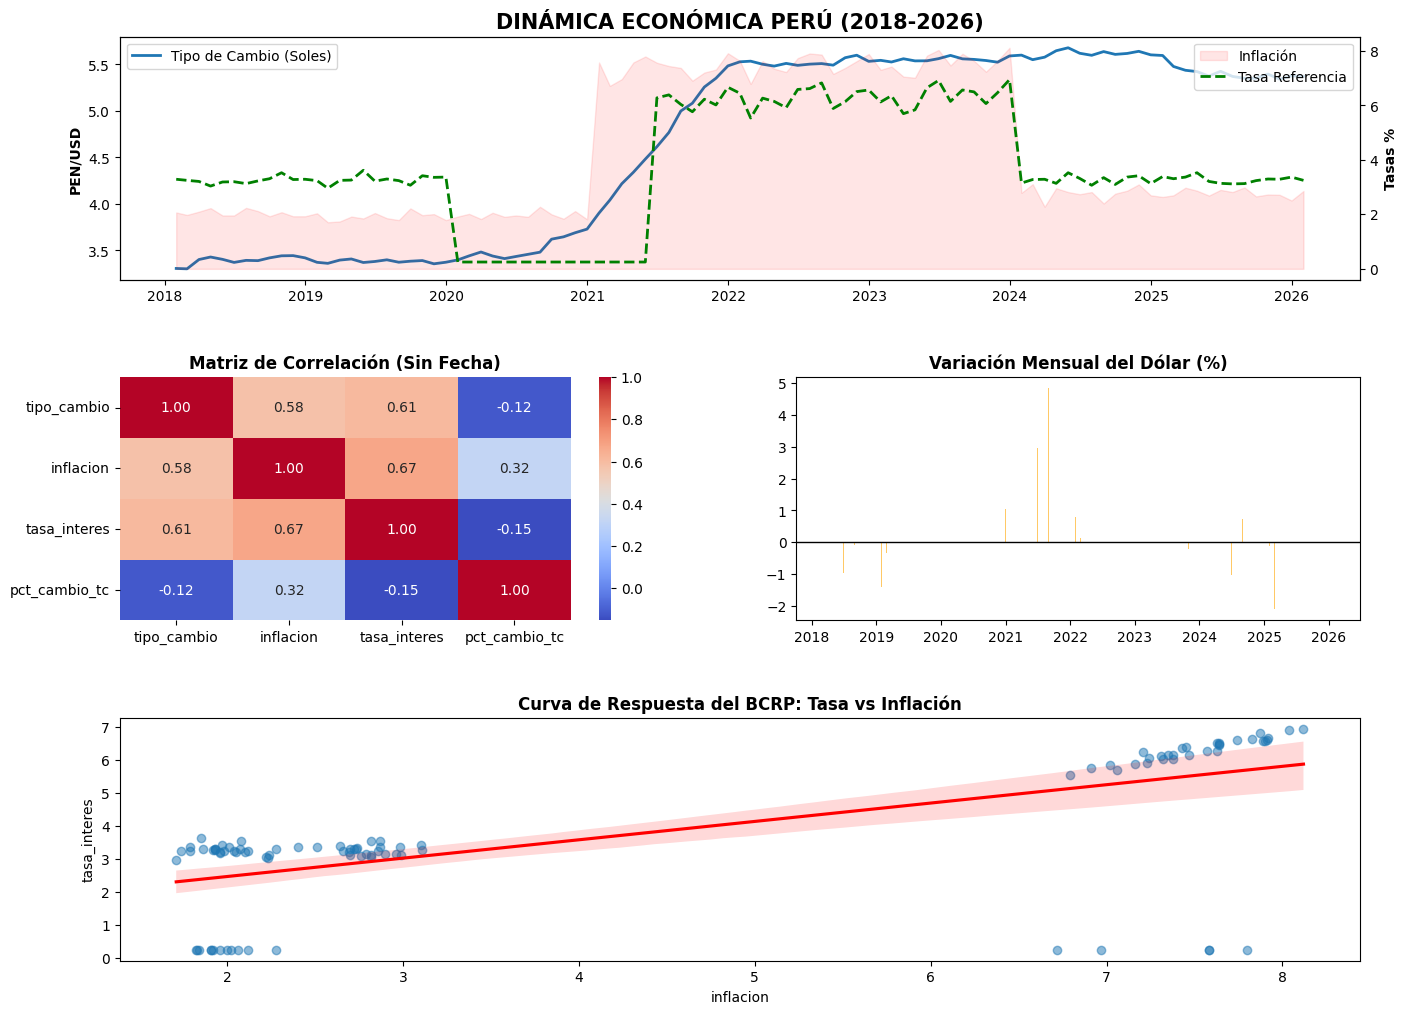

--- DATASET LISTO PARA DATABRICKS ---
        fecha  tipo_cambio  inflacion  tasa_interes  pct_cambio_tc
92 2025-09-30        5.351       2.66          3.24       0.000000
93 2025-10-31        5.396       2.73          3.30       0.840964
94 2025-11-30        5.341       2.72          3.29      -1.019274
95 2025-12-31        5.376       2.51          3.37       0.655308
96 2026-01-31        5.372       2.86          3.25      -0.074405


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. GENERACIÓN DE DATA CON LÓGICA MACROECONÓMICA (SIN CORRELACIONES ESPURIAS)
def generar_dataset_final():
    fechas = pd.date_range(start='2018-01-01', end='2026-02-01', freq='ME')
    n = len(fechas)
    np.random.seed(42)

    # Simulación de Inflación (Choque en 2022)
    inflacion = []
    for f in fechas:
        if f.year < 2021: base = 2.0 + np.random.normal(0, 0.15)
        elif 2021 <= f.year <= 2023: base = 7.5 + np.random.normal(0, 0.4)
        else: base = 2.8 + np.random.normal(0, 0.2)
        inflacion.append(base)

    # Simulación de Tasa (Reacción del BCRP)
    tasa_interes = []
    for i, f in enumerate(fechas):
        if f.year == 2020 or (f.year == 2021 and f.month < 6): val = 0.25
        elif inflacion[i] > 4: val = inflacion[i] - 1.2 + np.random.normal(0, 0.1)
        else: val = 3.25 + np.random.normal(0, 0.15)
        tasa_interes.append(val)

    # Simulación de Tipo de Cambio (Volatilidad y Reversión a la media)
    tc = []
    curr = 3.25
    for i, f in enumerate(fechas):
        step = np.random.normal(0, 0.035)
        bias = 0.15 if f.year == 2021 else -0.005 if f.year >= 2024 else 0.005
        curr += step + bias
        tc.append(curr)

    df = pd.DataFrame({
        'fecha': fechas,
        'tipo_cambio': np.round(tc, 3),
        'inflacion': np.round(inflacion, 2),
        'tasa_interes': np.round(tasa_interes, 2)
    })

    # 2. FEATURE ENGINEERING (Variaciones Porcentuales)
    # Esto es lo que realmente analizarás en Databricks
    df['pct_cambio_tc'] = df['tipo_cambio'].pct_change() * 100
    return df

# Ejecución
df_final = generar_dataset_final()

# 3. EDA PROFESIONAL EN UN SOLO BLOQUE VISUAL
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.4)

# A. Visualización de Series (Temporal)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df_final['fecha'], df_final['tipo_cambio'], color='#1f77b4', lw=2, label='Tipo de Cambio (Soles)')
ax1.set_ylabel('PEN/USD', fontweight='bold')
ax1_2 = ax1.twinx()
ax1_2.fill_between(df_final['fecha'], df_final['inflacion'], color='red', alpha=0.1, label='Inflación')
ax1_2.plot(df_final['fecha'], df_final['tasa_interes'], color='green', lw=2, ls='--', label='Tasa Referencia')
ax1_2.set_ylabel('Tasas %', fontweight='bold')
ax1.set_title('DINÁMICA ECONÓMICA PERÚ (2018-2026)', fontsize=15, fontweight='bold')
ax1.legend(loc='upper left'); ax1_2.legend(loc='upper right')

# B. Matriz de Correlación Limpia (SOLO NUMÉRICA)
ax2 = fig.add_subplot(gs[1, 0])
# Excluimos 'fecha' explícitamente para evitar la correlación espuria
cols_eco = ['tipo_cambio', 'inflacion', 'tasa_interes', 'pct_cambio_tc']
sns.heatmap(df_final[cols_eco].corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=ax2)
ax2.set_title('Matriz de Correlación (Sin Fecha)', fontweight='bold')

# C. Volatilidad del Tipo de Cambio
ax3 = fig.add_subplot(gs[1, 1])
ax3.bar(df_final['fecha'], df_final['pct_cambio_tc'], color='orange', alpha=0.6)
ax3.set_title('Variación Mensual del Dólar (%)', fontweight='bold')
ax3.axhline(0, color='black', lw=1)

# D. Relación Causa-Efecto (Scatter con Regresión)
ax4 = fig.add_subplot(gs[2, :])
sns.regplot(data=df_final, x='inflacion', y='tasa_interes', ax=ax4, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
ax4.set_title('Curva de Respuesta del BCRP: Tasa vs Inflación', fontweight='bold')

plt.show()

# Exportar para Databricks
df_final.to_csv("macro_peru_ready.csv", index=False)
print("--- DATASET LISTO PARA DATABRICKS ---")
print(df_final.tail())